## 範例重點
* 學習如何在 keras 中加入自定義的 callbacks
* 知道 callback function 可以動作的時機

In [1]:
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os

#Blas GEMM launch failed , 避免動態分配GPU / CPU, 出現問題
import tensorflow as tf
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# 資料前處理 -Y 轉成 onehot
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [10]:
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [7]:
"""
# 載入 Callbacks，撰寫一個 f1 score 的 callback function
"""

from keras.callbacks import Callback
from sklearn.metrics import f1_score

class f1sc(Callback):
    def on_train_begin(self, epoch, logs = {}):
        logs = logs or {}
        record_items = ["val_auc", "val_f1sc", "val_fp", "val_fn", "val_tp", "val_tn"]
        for i in record_items:
            if i not in self.params['metrics']:
                self.params['metrics'].append(i)
    
    def on_epoch_end(self, epoch, logs = {}, thres=0.5):
        logs = logs or {}
        y_true = self.validation_data[1].argmax(axis = 1)
        y_pred = self.model.predict(self.validation_data[0])
        y_pred = (y_pred[:, 1] >= thres) * 1
        
        logs["val_f1sc"] = f1_score(y_true = y_true, y_pred = y_pred, average="weighted")
        
log_f1sc = f1sc()

In [8]:
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[log_f1sc]
         )

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["acc"]
valid_acc = model.history.history["val_acc"]

# 在訓練後，將 f1sc 紀錄調出
valid_f1sc = model.history.history['val_f1sc']

W0904 11:16:08.263794 140315338004288 deprecation_wrapper.py:119] From /home/yun/.conda/envs/tf_keras/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0904 11:16:08.264531 140315338004288 deprecation_wrapper.py:119] From /home/yun/.conda/envs/tf_keras/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0904 11:16:08.266107 140315338004288 deprecation_wrapper.py:119] From /home/yun/.conda/envs/tf_keras/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0904 11:16:08.315497 140315338004288 deprecation_wrapper.py:119] From /home/yun/.conda/envs/tf_keras/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:148: The name tf.placeholder_with_default is deprecated. P

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512 

/home/yun/.conda/envs/tf_keras/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


50000/50000 [==============================] - 1s 12us/step - loss: 1.7428 - acc: 0.3914 - val_loss: 1.7850 - val_acc: 0.3797
Epoch 3/50
50000/50000 [==============================] - 1s 11us/step - loss: 1.6179 - acc: 0.4332 - val_loss: 1.6836 - val_acc: 0.4134
Epoch 4/50
50000/50000 [==============================] - 1s 13us/step - loss: 1.5402 - acc: 0.4582 - val_loss: 1.6253 - val_acc: 0.4351
Epoch 5/50
50000/50000 [==============================] - 1s 11us/step - loss: 1.4853 - acc: 0.4779 - val_loss: 1.6025 - val_acc: 0.4368
Epoch 6/50
50000/50000 [==============================] - 1s 12us/step - loss: 1.4380 - acc: 0.4966 - val_loss: 1.5659 - val_acc: 0.4476
Epoch 7/50
50000/50000 [==============================] - 1s 11us/step - loss: 1.3982 - acc: 0.5106 - val_loss: 1.5397 - val_acc: 0.4538
Epoch 8/50
50000/50000 [==============================] - 1s 12us/step - loss: 1.3625 - acc: 0.5235 - val_loss: 1.5226 - val_acc: 0.4631
Epoch 9/50
50000/50000 [============================

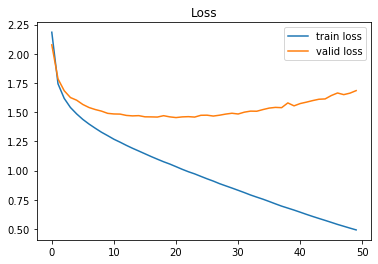

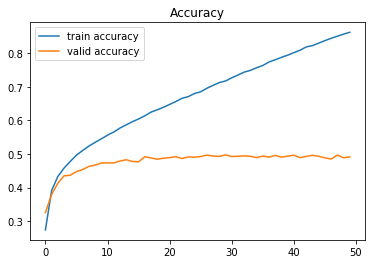

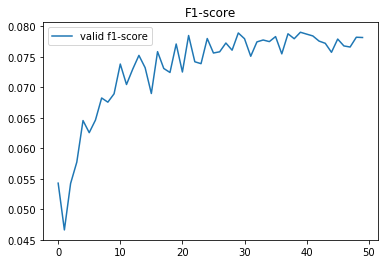

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

plt.plot(range(len(valid_f1sc)), valid_f1sc, label="valid f1-score")
plt.legend()
plt.title("F1-score")
plt.show()


## Work
1. 請嘗試寫一個 callback 用來記錄各類別在訓練過程中，對驗證集的 True Positive 與 True Negative

In [24]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [85]:
from keras.callbacks import Callback
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
class extract(Callback):
    def on_train_begin(self, epoch, logs = {}):
        logs = logs or {}
        record_items = ["val_auc", "val_f1sc", "val_fp", "val_fn", "val_tp", "val_tn"]
        for i in record_items:
            if i not in self.params['metrics']:
                self.params['metrics'].append(i)
    
    def on_epoch_end(self, epoch, logs = {}, thres=0.5):
        logs = logs or {}
        y_true = self.validation_data[1].argmax(axis = 1)
        y_pred = self.model.predict(self.validation_data[0])
        y_pred_code = []

        for i in range (0,y_pred.shape[0]):
            y_pred_code.append((y_pred[i].tolist().index(max(y_pred[i]))))
        print(confusion_matrix(y_true, y_pred_code)) 
        print(confusion_matrix(y_true, y_pred_code).shape)
        print(confusion_matrix(y_true, y_pred_code).diagonal().sum())
        logs["val_tp"] = confusion_matrix(y_true, y_pred_code).diagonal().sum()
        logs["val_tn"] = y_pred.shape[0]-confusion_matrix(y_true, y_pred_code).diagonal().sum()
log_extract = extract()

In [86]:
keras.backend.clear_session()
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[log_extract]
         )

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["acc"]
valid_acc = model.history.history["val_acc"]

# 在訓練後，將 f1sc 紀錄調出
# valid_tn = model.history.history['val_tn']

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512 

50000/50000 [==============================] - 1s 11us/step - loss: 1.2252 - acc: 0.5779 - val_loss: 1.4817 - val_acc: 0.4782
[[558  28  70  31  37  26  20  41 130  59]
 [ 64 530  26  27  15  20  25  37  59 197]
 [ 70  23 318  79 168 107 115  77  21  22]
 [ 28  22  73 295  68 235 133  74  24  48]
 [ 39   8 122  67 381  68 139 122  34  20]
 [ 15  14  72 175  74 430  71  93  29  27]
 [  7  18  79  86 124  75 546  37  13  15]
 [ 34  19  47  64  57  99  36 575  15  54]
 [134  48  18  32  31  37  15  22 594  69]
 [ 59 145  15  33  20  30  25  59  59 555]]
(10, 10)
4782
Epoch 14/50
50000/50000 [==============================] - 1s 10us/step - loss: 1.2004 - acc: 0.5872 - val_loss: 1.4722 - val_acc: 0.4844
[[584  38  47  18  38  16  22  35 144  58]
 [ 59 553  23  20  11  23  24  37  71 179]
 [ 81  26 334  80 168  69 122  80  21  19]
 [ 43  24  84 280  77 197 146  68  33  48]
 [ 48   7 122  68 411  46 138 111  34  15]
 [ 26  15  78 167  89 379  83  99  38  26]
 [ 15  19  80  77 122  55 565  35

50000/50000 [==============================] - 1s 10us/step - loss: 0.9192 - acc: 0.6938 - val_loss: 1.4887 - val_acc: 0.4913
[[527  35  91  25  36  16  19  56 138  57]
 [ 41 552  24  18  13  22  22  40  75 193]
 [ 62  18 414  76 119  72  91 106  18  24]
 [ 35  22 114 291  66 198 112  95  20  47]
 [ 47   3 183  75 366  53  93 137  26  17]
 [ 12   9  98 176  78 387  67 124  28  21]
 [  8  17 113  81 112  61 530  44  16  18]
 [ 20  15  64  59  55  61  24 622  19  61]
 [ 85  54  31  30  24  24  11  22 646  73]
 [ 32 151  25  34  12  28  17  61  62 578]]
(10, 10)
4913
Epoch 28/50
50000/50000 [==============================] - 1s 10us/step - loss: 0.8999 - acc: 0.7006 - val_loss: 1.4854 - val_acc: 0.4898
[[589  31  82  28  39  15  24  40 101  51]
 [ 50 539  16  26  14  21  26  42  52 214]
 [ 71  21 392  73 131  84 112  83  12  21]
 [ 37  17  97 282  64 245 132  69  13  44]
 [ 47   0 149  71 389  72 118 115  20  19]
 [ 17  10 101 165  72 439  69  86  22  19]
 [  7  18  92  78 111  84 555  30

50000/50000 [==============================] - 1s 11us/step - loss: 0.6500 - acc: 0.7998 - val_loss: 1.5880 - val_acc: 0.4886
[[618  42  64  31  31  18  25  25  94  52]
 [ 55 565  23  26  12  24  31  27  49 188]
 [ 89  21 453  81  74  71 104  74  11  22]
 [ 39  22 118 310  54 207 142  58  11  39]
 [ 56   6 219  77 303  74 137  94  19  15]
 [ 23  13 117 183  57 411  77  79  19  21]
 [ 12  24 122  82  71  66 577  23  10  13]
 [ 44  21  79  65  59  89  33 546   7  57]
 [146  69  26  33  30  30  19  16 553  78]
 [ 51 169  26  38  13  24  29  56  44 550]]
(10, 10)
4886
Epoch 42/50
50000/50000 [==============================] - 1s 12us/step - loss: 0.6323 - acc: 0.8062 - val_loss: 1.5995 - val_acc: 0.4854
[[551  40 121  25  33  14  13  32 126  45]
 [ 45 559  26  28  13  23  17  31  78 180]
 [ 48  21 493  75 108  76  57  80  17  25]
 [ 33  24 144 297  62 225  76  71  21  47]
 [ 40   7 220  71 375  78  70  97  22  20]
 [ 17  12 135 161  80 438  31  81  24  21]
 [ 14  25 165 116 106  81 428  31

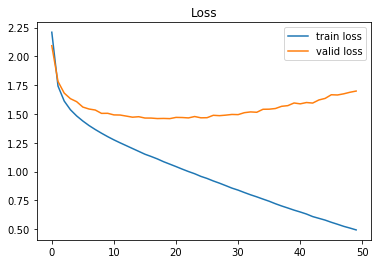

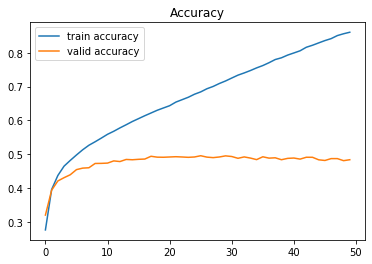

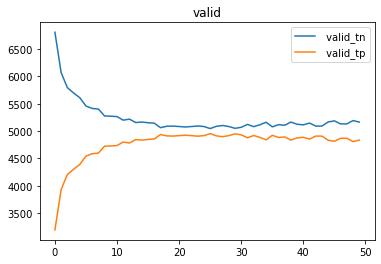

In [87]:
valid_tn = model.history.history['val_tn']
valid_tp = model.history.history['val_tp']

import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

plt.plot(range(len(valid_tn)), valid_tn, label=" valid_tn")
plt.plot(range(len(valid_tp)), valid_tp, label=" valid_tp")
plt.legend()
plt.title("valid")
plt.show()